# **My own understanding (notes)**
**Convolution Neural Networks (CNNs)**: Type of Deep Learning often used in Computer Vision. Ex: CNN helps compute the most likely class an input image belongs to in image classification.
CNN has hidden layers that use convolution layers.

**Convolution layers**: detect patterns. At each convolution layer, # of filters/kernels/masks must be determined. At the start of network, filters often capture geometric patterns (edge, shape, etc) in images. Deeper in the network, filters are able to capture sophisticated patterns like what object is in image, etc.

When inputting images, computer gets matrix of pixels.
> colored images = 3D matrix with RGB values 0-255

> black-and-white images = 2D arrays with binary values 0-1

*CNN pros*:
* Powerful function approximators
* Accuracy improved through backpropagation

*CNN cons*:
* Usage of so many parameters causes Gradient Vanish issue because of long chains
* Image classification is sensitive to translation, scaling, rotation, or any image variational changes.


## CNN basic pipeline
1. Input an image
2. Do Convolution operation to get activation map
3. Apply pooling layer to make model robust
4. Activation function (often ReLU) applied to avoid nonlinearity
5. Flatten last output into 1 linear vector
6. Vector passed to fully connected artificial neural network
7. Fully connected layer gives probability for each target class
8. Repeat process to train weights to detect features

## Convolution layer
**Convolution filter/mask/kernel/template/window**: Extract features like geometric patterns/edge/contrast/blur from image. Computes filter value ⋅ image pixel values = convolution layer. Values in filter matrix updated at each backpropagation but dimensions are pre-determined ahead of time by programmer and stay constant.
* The more the filter, the more features the model learns
* Each filter applied to 3D input outputs 2D output. Combination of all 2D outputs result in final 3D output.
* If original dimension of image is (h,w,c), after using convolution, dimensions of output image reduced to (h-f+1, w-f+1, c)

Convolution formula
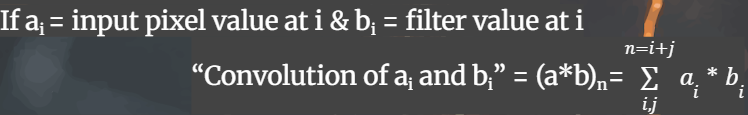

**Padding**: Helps output image have same dimensions as input. Padding adds 0s to every channel. The bigger the kernel, the larger the padding must be.


**Stride**: To get activation map, usually skip 1 pixel either downwards/sideward but to skip custom # of pixels, use stride. The greater the stride, the less the output dimension. Ex: If original image dimensions = (h,w,c), after stride dimensions = h-fs+1,w-fs+1,c

**padding + stride**
If both padding + stride performed, output dimensions = h-f+2*pads+1,w-f+2*pads+1,c

## Pooling layer
To improve feature detection, CNN replaces output with max summary to reduce data size & processing time. This lets programmers focus on features with most prominent features.
**Max pooling**: Takes 2 hyperparameters: stride & size.
* Stride = # of values to be skipped
* Size = Area of every skipped value pool

## Activation function
ReLU & Sigmoid activation functions added to introduce nonlinearity for values x > 0 (positive values). It returns 0 if value isn’t positive.

This solves vanishing gradient problem (when gradients become too small and slow down learning bc weights are being updated at tiny increments) bc very small weights remain at 0 after ReLU activation function
fully connected artificial neural network layer

Final layer takes in input of flattened feature output to a column vector into softmax activation function which will assign probability for each class.
every node in previous layer connected to last layer & represents distinct label to output


## Backpropagation
Backpropagation recursively trains model to learn optimal weights & biases.

Weights and biases slowly pick up on the features that make certain images fall into a certain class.

## CNN limitations & solutions
Problem - When dataset is small, model may overfit.

Solution - Add images with slight variations, changing color, scaling, cropping, flipping, translations, etc.


Problem - When model has too many layers, too many features are learned and model can’t generalize properly because it’s too specialized.

Solution - Dropout. Drop random neurons w/ every epoch. This will average out all outputs. Dropped out neurons won’t be updated using backpropagation.


Colab tutorial for uploading data.

https://colab.research.google.com/notebooks/io.ipynb

# Instructions

[Project3 Tutorial](https://www.youtube.com/watch?v=IfFhFTxwU9A)

1. Defining the problem: For each recording, the raw signal in different states are provided separately. You need to preprocess the raw data and create your own input data and output labels for the two states. You need to cut the recording into small clips of certain fixed length (e.g. 5 seconds). Each clip will be a data sample and corresponds to a label of state.

2. Designing model inputs: You can try using directly the raw signal as input or you can apply techniques you learned from signal processing to extract features from the raw signal and use the extracted features as input. The prediction gets more difficult (i.e. lower accuracy) as the length of a clip gets shorter (meaning higher time resolution in predicting the state). Hints for extracting input features:
> 1. Calculate statistics of each clip, e.g. mean, standard deviation, skewness, kurtosis, etc.
> 2. Calculate the PSD of each clip with low frequency resolution (i.e. using small length of segment for PSD estimation, a fraction of the clip length).
> 3. Find oscillation frequency bands (bumps) in the overall PSD of each state. Bandpass filter the signal within the frequency bands and get the statistics of each clip in that band (e.g. signal power within the band).
> 4. Perform normalization (z-score or min-max) to scale the magnitude of input features.

3. Train different network models for different subjects. But it's good to develop a general algorithm, i.e. using the same data processing scheme, same network architecture and hyperparameters, while the trained parameters in models for different subjects are distinct.

4. You are to explore methods in signal processing, feature engineering, network architectures, etc., to improve the performance and test the limits of your models. Also note all the issues you encountered when you develop the model, and state how you have solved them (not the technical issues like coding, but the issues related to machine learning).

# **Installs & imports**

In [ ]:
!pip install scipy --upgrade -q

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy import signal
from scipy.integrate import trapezoid
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# **Preprocess data**

In [19]:
def get_sampling_frequency(filepath: str, verbose: bool = False) -> float:
    sampling_frequency = 0 # default sampling frequency
    with h5py.File(filepath, "r") as file:
        sampling_frequency = file.attrs["fs"][0]
        if verbose:
            print(f"Sampling rate: {sampling_frequency} Hz")
    return sampling_frequency

def split_NREM_and_WAKE(filepath: str, verbose: bool = False) -> tuple:
    states = []
    with h5py.File(filepath, "r") as file:
        for name, group in file.items():
            states.append(name)
            if name == "NREM":
                NREM = list(group.keys())
            elif name == "WAKE":
                WAKE = list(group.keys())
            if verbose:
                print(f"State: {name}")
                # Under each h5 group, the LFP recordings are divided into several segments with different lengths.
                print(f"Segment IDs: {list(group.keys())}")
    return NREM, WAKE

def get_values_in_np_array(filepath: str, lfp: dict, verbose: bool = False) -> list:
    with h5py.File(filepath, "r") as file:
        for name, group in file.items():
            values = []
            for i in range(len(group)):
                values.append(group[str(i+1)][()].astype(float))

            lfp[name] = values # Add a list of numpy arrays of all segments to dictionary
            if verbose:
                print(f"State: {name}")
                print(f"values: {values}")
    return lfp

def plot_state_at_segment_num(state: str, segment_num: int, sampling_frequency:float, lfp: dict):
    x = lfp[state][segment_num]  # accessing the segment_num-th LFP segment in NREM state (THIS IS 0-based counting!!!!)
    t = np.arange(x.size)/sampling_frequency  # time points
    plt.plot(t,x)
    plt.xlabel("seconds")
    plt.ylabel("amplitude")
    plt.show()

def resplit_data_by_sec(seconds: int, sampling_frequency: float, lfp: dict, verbose: bool = False) -> dict:
    aggregated_segments = {}
    resplitted_segments = {}
    clip_length = int(seconds * sampling_frequency)
    for state in lfp:
        aggregated_segments[state] = np.concatenate(lfp[state])

    for state, signal in aggregated_segments.items():
        aggregated_segments[state] = np.concatenate(lfp[state])

        # Calculate the maximum number of full segments that can fit
        new_segments_count = len(aggregated_segments[state]) // clip_length

        # Trim the signal to fit the exact number of full segments
        trimmed_signal = aggregated_segments[state][:new_segments_count * clip_length]

        # Reshape the trimmed signal
        resplitted_segments[state] = trimmed_signal.reshape(new_segments_count, clip_length)
        if verbose:
            print(f"State = {state}\nSegments = {resplitted_segments[state]}")
    return resplitted_segments


In [20]:
def preprocess_data(filepath: str, seconds: int = 5, verbose: bool = False) -> dict:
    sampling_frequency = get_sampling_frequency(filepath, verbose)  # Number of data points collected per second
    NREM, WAKE = split_NREM_and_WAKE(filepath, verbose)
    lfp = {"NREM": NREM, "WAKE": WAKE}
    lfp = get_values_in_np_array(filepath, lfp, verbose=verbose)
    print("THIS IS ORIGINAL PLOT at 0th segment")
    plot_state_at_segment_num("NREM", 0, sampling_frequency, lfp)
    resplitted_segments = resplit_data_by_sec(5, sampling_frequency, lfp, verbose=verbose)
    print("\n\nTHIS IS RESPLITTED PLOT at 0th segment")
    plot_state_at_segment_num("NREM", 10, sampling_frequency, resplitted_segments)
    return resplitted_segments

Sampling rate: 1250.0 Hz
State: NREM
Segment IDs: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '7', '8', '9']
State: WAKE
Segment IDs: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '4', '5', '6', '7', '8', '9']
State: NREM
values: [array([ -73.,  -52., -112., ..., -163.,  -80.,   32.]), array([ 563.,  765.,  689., ..., -270., -278., -271.]), array([1027., 1036., 1040., ...,  321.,  342.,  369.]), array([ 442.,  410.,  302., ..., -300., -331., -334.]), array([ -88., -118., -133., ..., -522., -491., -537.]), array([ 262.,  375.,  442., ..., -177., -179., -309.]), array([ 

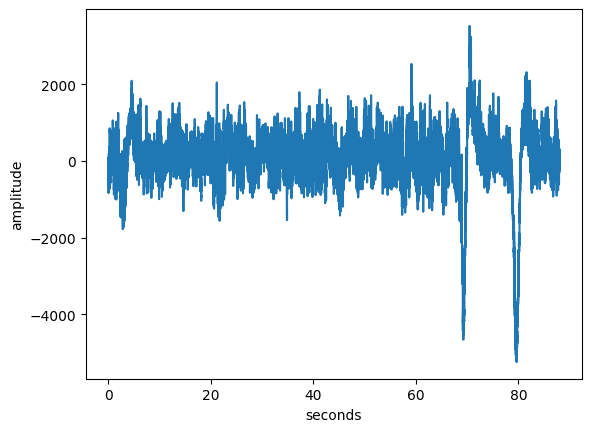

State = NREM
Segments = [[ -73.  -52. -112. ... 1049. 1135. 1046.]
 [ 996.  985.  963. ...  540.  539.  616.]
 [ 642.  570.  588. ... -117.  -77. -101.]
 ...
 [1346. 1328. 1354. ...  873.  825.  854.]
 [ 826.  733.  766. ...  397.  414.  463.]
 [ 497.  533.  560. ...  590.  614.  567.]]
State = WAKE
Segments = [[-5997. -5966. -5938. ...  1009.  1127.  1126.]
 [ 1034.   985.  1011. ...   576.   582.   421.]
 [  352.   218.   -48. ...  -244.  -200.   -11.]
 ...
 [  249.   264.   292. ...   474.   511.   557.]
 [  499.   416.   395. ...   610.   879.  1066.]
 [ 1193.  1277.  1297. ...  -614.  -652.  -547.]]


THIS IS RESPLITTED PLOT at 0th segment


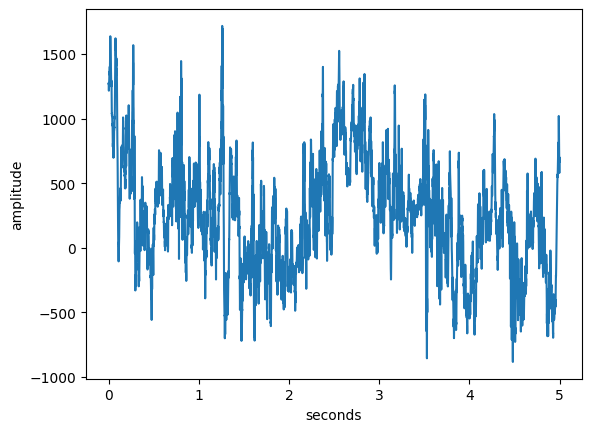

In [85]:
filename = "Rat08-20130711_017.h5" # Switch to Part1SubjectHB10.h5, Part2SubjectHB13.h5, or Rat08-20130711_017 then rerun entire notebook to see different model performances on different data
resplitted_segments = preprocess_data(filename, 5, True)
sampling_frequency = get_sampling_frequency(filename, False)

# **Design model inputs**


In [86]:
def min_max_normalization(data, new_min=0, new_max=1):
    # Calculate the min and max of the data
    old_min = np.min(data)
    old_max = np.max(data)

    # Apply min-max normalization
    normalized_data = (data - old_min) / (old_max - old_min)
    # Scale to the desired range [new_min, new_max]
    normalized_data = normalized_data * (new_max - new_min) + new_min

    return normalized_data

def get_psd(segment: np.ndarray, sampling_frequency: float):
    segment_length = int(sampling_frequency * len(segment))
    power_features = {}
    frequencies, psd = signal.welch(segment, fs=sampling_frequency, nperseg=1024)
    bands = {
        "delta": (0.5, 4),
        "theta": (4, 8),
        "alpha": (8, 12),
        "beta": (12, 30),
        "gamma": (30, 100)
    }
    for band_name, (low_freq, high_freq) in bands.items():
        band_mask = (frequencies >= low_freq) & (frequencies <= high_freq)

        # Compute the band power by integrating (summing) the PSD values in the frequency band
        band_power = trapezoid(psd[band_mask], frequencies[band_mask])
        power_features[band_name + '_power'] = band_power
    return psd, power_features

def dict_to_dataframe(resplitted_segments: dict, sampling_frequency: float, normalization: bool=False):
    data = []
    for state, values in resplitted_segments.items():
        for segment in values:
            if normalization:
                segment = min_max_normalization(segment)
            psd, power_features = get_psd(segment, sampling_frequency)
            row = {"State": state,
             "Avg": np.mean(segment),
             "Standard deviation": np.std(segment),
             "Skewness": skew(segment, axis=0, bias=True),
             "Kurtosis": kurtosis(segment, axis=0, bias=True),
            }
            row.update(power_features)
            data.append(row)

    return pd.DataFrame(data)

In [87]:
original_dataframe = dict_to_dataframe(resplitted_segments, sampling_frequency)
original_dataframe

,State,Avg,Standard deviation,Skewness,Kurtosis,delta_power,theta_power,alpha_power,beta_power,gamma_power
0,NREM,34.79200,698.170232,0.216061,-0.482159,35601.231638,17476.340248,10821.751771,27879.297206,9371.190960
1,NREM,162.48736,364.404725,0.409399,0.639195,20944.719469,13973.732061,10605.413523,26506.622458,8928.892930
2,NREM,185.21040,392.533268,0.200452,0.030759,19778.150893,10819.473943,10100.663362,25290.991248,7684.992210
3,NREM,163.97376,338.723616,-0.043639,-0.033875,19442.335478,15448.785743,5673.953717,9552.100145,7027.034266
4,NREM,33.76784,547.529262,-0.098687,-0.436766,58257.862496,12551.932601,20330.034171,29355.610324,7450.322658
...,...,...,...,...,...,...,...,...,...,...
3716,WAKE,-169.53824,2342.014096,-1.837800,3.703000,752363.058402,337934.255422,163855.959008,297228.141028,155004.803457
3717,WAKE,772.12480,738.198900,0.114314,-0.980347,18590.157834,16565.485473,6946.596242,11628.372049,10385.909758
3718,WAKE,244.48864,468.724402,-2.100329,17.260205,47631.251740,14019.111336,17210.428981,22995.182352,19343.877831
3719,WAKE,508.31440,1139.839309,-2.316939,8.051596,146688.266785,38460.432242,33292.486030,60222.681165,40894.466724


In [88]:
normalized_dataframe = dict_to_dataframe(resplitted_segments, sampling_frequency, normalization=True)
normalized_dataframe

,State,Avg,Standard deviation,Skewness,Kurtosis,delta_power,theta_power,alpha_power,beta_power,gamma_power
0,NREM,0.468301,0.180359,0.216061,-0.482159,0.002376,0.001166,0.000722,0.001861,0.000625
1,NREM,0.441452,0.138980,0.409399,0.639195,0.003047,0.002033,0.001543,0.003856,0.001299
2,NREM,0.528049,0.138999,0.200452,0.030759,0.002480,0.001357,0.001267,0.003171,0.000964
3,NREM,0.520317,0.146507,-0.043639,-0.033875,0.003637,0.002890,0.001061,0.001787,0.001315
4,NREM,0.441764,0.151670,-0.098687,-0.436766,0.004470,0.000963,0.001560,0.002253,0.000572
...,...,...,...,...,...,...,...,...,...,...
3716,WAKE,0.810502,0.151960,-1.837800,3.703000,0.003167,0.001423,0.000690,0.001251,0.000653
3717,WAKE,0.644951,0.170761,0.114314,-0.980347,0.000995,0.000886,0.000372,0.000622,0.000556
3718,WAKE,0.847835,0.055874,-2.100329,17.260205,0.000677,0.000199,0.000245,0.000327,0.000275
3719,WAKE,0.853524,0.099636,-2.316939,8.051596,0.001121,0.000294,0.000254,0.000460,0.000312


# **Evaluation function for models**

In [89]:
def evaluate_model(model, X_test, y_test, verbose: bool = True):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation during evaluation
        outputs = model(X_test)
        predicted = (outputs > 0.5).float()  # Convert probabilities to predictions (0 or 1)
        predicted = predicted.squeeze().cpu().numpy()  # Convert to NumPy array

    # Calculate metrics
    accuracy = accuracy_score(y_test, predicted)
    precision = precision_score(y_test, predicted)
    recall = recall_score(y_test, predicted)
    f1 = f1_score(y_test, predicted)

    if verbose:
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")

    return accuracy, precision, recall, f1

# **Train models**

## CNN model

1. Prepare data for CNN model

In [90]:
dataframe = normalized_dataframe
X = dataframe[['Avg', 'Standard deviation', 'Skewness', 'Kurtosis', 'delta_power', 'theta_power', 'alpha_power', 'beta_power', 'gamma_power']].values
y = pd.get_dummies(dataframe['State'])["WAKE"].values # Make WAKE states = 1 & NREM = 0

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Standardize features (changes distribution shape to be more Gaussian-like by centering data around 0 then scaling based on its spread.)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape data for CNN input (samples, channels, height, width)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], 1) # Since this is time-series data, channel isn't 3 like in RGB pixels, height is # of features, width is just 1 bc it isn't img data
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], 1)

# Conver to tensor float objs
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

2. Run CNN model

In [91]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 1), stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 1))
        self.pool = nn.MaxPool2d(kernel_size=(2, 1))
        self.fc1_input_size = self._get_fc1_input_size(X_train.shape)
        self.fc1 = nn.Linear(self.fc1_input_size, 128)
        self.fc2 = nn.Linear(128, 1)
    def _get_fc1_input_size(self, input_shape):
        """Calculates the input size for fc1 based on the input shape."""
        # Pass a dummy input through the convolutional layers to get the output shape
        dummy_input = torch.zeros(1, *input_shape[1:])  # Create a dummy input with batch size 1
        output = self.pool(F.relu(self.conv2(F.relu(self.conv1(dummy_input)))))
        # Return the flattened size of the output
        return output.view(-1).shape[0]
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.fc1_input_size)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model = CNN()
criterion = nn.BCELoss()  # Binary Cross-Entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 70 # Initial value was 20
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs.squeeze(), y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/70], Loss: 0.6807
Epoch [2/70], Loss: 0.6701
Epoch [3/70], Loss: 0.6607
Epoch [4/70], Loss: 0.6520
Epoch [5/70], Loss: 0.6436
Epoch [6/70], Loss: 0.6355
Epoch [7/70], Loss: 0.6275
Epoch [8/70], Loss: 0.6195
Epoch [9/70], Loss: 0.6115
Epoch [10/70], Loss: 0.6032
Epoch [11/70], Loss: 0.5947
Epoch [12/70], Loss: 0.5858
Epoch [13/70], Loss: 0.5764
Epoch [14/70], Loss: 0.5661
Epoch [15/70], Loss: 0.5550
Epoch [16/70], Loss: 0.5432
Epoch [17/70], Loss: 0.5308
Epoch [18/70], Loss: 0.5181
Epoch [19/70], Loss: 0.5054
Epoch [20/70], Loss: 0.4928
Epoch [21/70], Loss: 0.4801
Epoch [22/70], Loss: 0.4673
Epoch [23/70], Loss: 0.4545
Epoch [24/70], Loss: 0.4418
Epoch [25/70], Loss: 0.4293
Epoch [26/70], Loss: 0.4174
Epoch [27/70], Loss: 0.4061
Epoch [28/70], Loss: 0.3954
Epoch [29/70], Loss: 0.3853
Epoch [30/70], Loss: 0.3756
Epoch [31/70], Loss: 0.3663
Epoch [32/70], Loss: 0.3573
Epoch [33/70], Loss: 0.3487
Epoch [34/70], Loss: 0.3405
Epoch [35/70], Loss: 0.3327
Epoch [36/70], Loss: 0.3256
E

3. Evaluation

In [92]:
CNN_accuracy, CNN_precision, CNN_recall, CNN_f1 = evaluate_model(model, X_test, y_test, verbose=True)

Accuracy: 0.8644
Precision: 0.8951
Recall: 0.8894
F1-Score: 0.8922


## LSTM
1. Prepare data for LSTM model

In [93]:
dataframe = normalized_dataframe
X = dataframe[['Avg', 'Standard deviation', 'Skewness', 'Kurtosis', 'delta_power', 'theta_power', 'alpha_power', 'beta_power', 'gamma_power']].values
y = pd.get_dummies(dataframe['State'])["WAKE"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])  # (samples, sequence_length=1, features=9)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])  # (samples, 1, 9)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Ensure shape (batch_size, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)  # Ensure shape (batch_size, 1)

# Create DataLoader
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

2. Run LSTM model

In [94]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        _, (h_n, _) = self.lstm(x) # Get the last hidden state
        return torch.sigmoid(self.fc(h_n[-1])) # Sigmoid for binary classification
input_size = X_train.shape[2]  # Number of features
hidden_size = 64
model = LSTM(input_size, hidden_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()  # Reset gradients

        outputs = model(batch_X)  # Forward pass
        loss = criterion(outputs, batch_y)  # Compute loss

        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 0.4348
Epoch [2/10], Loss: 0.2845
Epoch [3/10], Loss: 0.1451
Epoch [4/10], Loss: 0.1836
Epoch [5/10], Loss: 0.1267
Epoch [6/10], Loss: 0.2817
Epoch [7/10], Loss: 0.3384
Epoch [8/10], Loss: 0.2498
Epoch [9/10], Loss: 0.0656
Epoch [10/10], Loss: 0.1293


3. Evaluation

In [95]:
LSTM_accuracy, LSTM_precision, LSTM_recall, LSTM_f1 = evaluate_model(model, X_test, y_test, verbose=True)

Accuracy: 0.9235
Precision: 0.9479
Recall: 0.9298
F1-Score: 0.9388


# **Discussion & Conclusion**
## methods
CNN - 2 convolution layers, each has 32 filters & uses a 3x1 kernel/window.
Apply ReLU to 1st convolution layer
Apply ReLU to 2nd convolution layer AND pooling using 2x1 kernel.
Pass into fully connected network with 128 hidden nodes, output 1 vlaue/node
Output layer passed through sigmoid for binary classification


LSTM - 1 hidden layer with 64 hidden nodes. Sigmoid function applied to input & output "gates", and also when determining which past state can be "forgotten"/discarded from affecting current prediction. Tanh function applied at candidate cell state update when determining which states to "remember"/keep. Finally, Sigmoid layer at end of output layer to convert values to binary values (0 for NREM 0 or 1 for WAKE)

## Encountered ML problems & solutions
I was having many problems improving the accuracy/other metrics of CNN past 0.4. In the end, I increased my number of epochs, which allowed for the CNN model to train with the data for longer and better capture the underlying technique to classification between NREM & WAKE states.

## **results**
### (for Part1SubjectHB10.h5)
CNN Accuracy: 0.9505

CNN Precision: 0.9652

CNN Recall: 0.9569

CNN F1-Score: 0.9610

LSTM Accuracy: 0.9780

LSTM Precision: 0.9828

LSTM Recall: 0.9828

LSTM F1-Score: 0.9828

### (for Part2SubjectHB13.h5)
CNN Accuracy: 0.9016

CNN Precision: 0.9412

CNN Recall: 0.9106

CNN F1-Score: 0.9256

LSTM Accuracy: 0.9290

LSTM Precision: 0.9911

LSTM Recall: 0.9024

LSTM F1-Score: 0.9447


### (for Rat08-20130711_017.h5)

CNN Accuracy: 0.8671

CNN Precision: 0.8955

CNN Recall: 0.8936

CNN F1-Score: 0.8946

LSTM Accuracy: 0.9208

LSTM Precision: 0.9497

LSTM Recall: 0.9234

LSTM F1-Score: 0.9364


## findings
After doing online research, I added Long-Short Term Memory (LSTM) as another network model to try out. LSTM models are good models for learning data that have dependencies upon past data. For example in English sentence translation the meaning of a word may depend on previous words up to that point, therefore previous data (words) should also have weight in predictions. The same is true for the rat08 h5 data. There is high likelyhood if the previous few states were WAKE then the next state will also be WAKE. Thus, I think this contributes to the score improvement on all metrics when training with LSTM model versus training with CNN model which may not take into account past states as predictors of what the current state may be.
## insights

Although the accuracy (correct classifications/total classifications) is high (~0.87), if entire Rat08 dataset is skewed towards NREM or WAKE then this metric is an inaccurate representation of model's actual performance.


---


Precision (correct positives / all correct & incorrect positives) when actual positives (actual WAKE states) is balanced/high in dataset. The score (~0.90) is high, meaning model makes accurate predicitions about if rat is in WAKE state.


---

Recall (correct positives / all real positives) when false negatives (NREM misclassified as WAKE) is more detrimental to classification task. The recall score (\~0.89) is similar to accuracy score (~0.87), which can be (not always) a sign that Rat08 dataset is relatively balanced.
* But because we don't know what this classification of rat states are for, we can't be sure if recall score is useful
* ~89% of NREM were able to be classified by model which is relatively good and an indicator that model isn't overfitting.

---

F1-score is a combination of recall & precision metrics without the inability to account for imbalanced datasets (as is the case for simple accuracy scores).
* Since we don't know if classification task would penalize incorrect NREMs or reward correct WAKE classification predictions more, f1-score can be a balance of both, assuming that both are equally important. CNN model with ~90% for f1 score is relatively good without the score being too high (which means it's overfitting)
